# Notebook pour evaluer les résumés avec un llm juge

In [1]:
# Classiques
import pandas as pd
import numpy as np
from IPython.display import Markdown
import requests

import asyncio
import async_timeout

import getpass
import os

from tqdm import tqdm
tqdm.pandas()

#Langchain and LLMs
import json
from langchain_community.chat_models import ChatOllama
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from langchain_core.prompt_values import StringPromptValue
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI


## Prompts utilisés

In [2]:
example_json={
    "Clarity":"(numeric value 1-5)",
    "Accuracy":"(numeric value 1-5)",
    "Coverage":"(numeric value 1-5)",
    "Overall quality":"(numeric value 1-5)",
    "Explanations": 
    {
        "Clarity": "Your explanations about clarity....",
        "Accuracy": "Your explanations about accuracy....",
        "Coverage": "Your explanations about coverage....",
        "Overall quality": "Your explanations about overall quality....",
    }}
example_json_string=json.dumps(example_json)

example_json_refBased={
    "Accuracy": "(numeric value 1-5)",
    "Conciseness": "(numeric value 1-5)",
    "Structure": "(numeric value 1-5)",
    "Explanations": {
        "Accuracy": "Your explanations about accuracy....",
        "Conciseness": "Your explanations about conciseness....",
        "Structure": "Your explanations about structure....",
    }
}
example_json_string_refBased=json.dumps(example_json_refBased)

evaluation_refFree_prompt = PromptTemplate(
    template=
        """
        You are an expert in evaluating summaries. 
        Assess the provided summary against its source document using the following four dimensions:

        (1) Clarity: whether the summary is reader-friendly and expresses ideas clearly.
        (2) Accuracy: whether the summary contains the same information as the source document.
        (3) Coverage: how well the summary covers the important information from the source document.
        (4) Overall quality: how good the summary overall at representing the source document; a good summary is a shorter piece of text that has the essence of the original, tries to convey the same information as the source document.

        For each dimension, give a numerical rating on a Likert-scale from 1 to 5 (1 = Poor, 5 = Excellent). Ensure that each of the first four keys contains only a single numeric value.
        Your response should be in JSON format with five keys:
        - 'Clarity': Numeric score (1-5) indicating the clarity of the summary.
        - 'Accuracy': Numeric score (1-5) indicating the accuracy of the summary.
        - 'Coverage': Numeric score (1-5) indicating the coverage of the summary.
        - 'Overall quality': Numeric score (1-5) indicating the overall quality of the summary.
        - 'Explanations': A brief explanation for each score given, detailing the reasons behind the evaluation.

        Materials for evaluation:
        - Summary: {summary}
        - Source Document: {document}

        Example output format:
        {example_output}
        """,
        input_variables=["document","summary"],
    )
evaluation_refBased_prompt = PromptTemplate(
    template=
        """
        You are an expert in comparing summaries. 
        Assess the provided summary against the reference summary based on the following three dimensions:

        (1) Accuracy: Evaluate how well the provided summary reflects the same information as the reference summary.
        (2) Conciseness: Assess whether the provided summary presents the information as concisely as the reference summary, avoiding unnecessary details and focusing on the core message.
        (3) Structure: Determine if the provided summary follows a similar structure to the reference summary.

        For each dimension, give a numerical rating on a Likert-scale from 1 to 5 (1 = Poor, 5 = Excellent). Ensure that each of the first three keys contains only a single numeric value.
        Your response should be in JSON format with four keys:
        - 'Accuracy': Numeric score (1-5) indicating the accuracy of the summary.
        - 'Conciseness': Numeric score (1-5) indicating the conciseness of the summary.
        - 'Structure': Numeric score (1-5) indicating how well the summary mirrors the structure of the reference.
        - 'Explanations': A brief explanation for each score given, detailing the reasons behind the evaluation.

        Materials for evaluation:
        - Summary to Analyze: {summary}
        - Reference Summary: {ref_summary}

        Example output format:
        {example_output}
        """,
        input_variables=["ref_summary","summary"],
    )

#POUR ENCOURAGER LA VARIANCE
evaluation_refFree_prompt_var = PromptTemplate(
    template=
        """
        Task: As an expert in summary evaluation, carefully assess the provided summary against its source document based on the following four dimensions:

        (1) Clarity: Evaluate how clearly and effectively the summary communicates ideas to the reader. Consider variations in wording, sentence structure, and overall readability.
        (2) Accuracy: Determine if the summary accurately reflects the information from the source document. Pay close attention to both major and minor discrepancies or omissions.
        (3) Coverage: Assess how comprehensively the summary captures the key information from the source document. Consider the inclusion and omission of both primary and secondary details.
        (4) Overall quality: Rate the overall effectiveness of the summary in representing the essence of the source document. Consider how well the summary balances brevity and completeness.
        For each dimension, assign a numerical score on a Likert scale from 1 to 5 (1 = Poor, 5 = Excellent). Please ensure that your scoring reflects nuanced differences between summaries. Each score should be a single numeric value.
        
        Response Format: Your response should be in JSON format with the following keys:
        - 'Clarity': Numeric score (1-5) for clarity.
        - 'Accuracy': Numeric score (1-5) for accuracy.
        - 'Coverage': Numeric score (1-5) for coverage.
        - 'Overall quality': Numeric score (1-5) for overall quality.
        - 'Explanations': A brief explanation justifying each score, reflecting on subtle distinctions and specific aspects of the summary.

        Materials for evaluation:
        - Summary: {summary}
        - Source Document: {document}

        Example output format:
        {example_output}

        Additional Considerations:
        - Nuanced Judgments: While evaluating, take into account the wide range of possible summary qualities. Even small variations should be reflected in the scores, leading to a diverse range of assessments.
        - Consistency: Avoid consistently assigning the same score across different summaries unless they truly exhibit the same quality. The goal is to capture the true variability in summary quality.
        """,
        input_variables=["document","summary"],
    )
# Example output format:
#         {example_output}
evaluation_refBased_prompt_var = PromptTemplate(
    template=
        """
        Task: As an expert in summary comparison, carefully evaluate the provided summary against the reference summary based on the following three dimensions:

        (1) Accuracy: Critically assess how well the provided summary captures the same information as the reference summary. Consider both major and subtle differences in content, including any omissions or discrepancies.
        (2) Conciseness: Evaluate the efficiency of the provided summary in conveying the core message compared to the reference summary. Pay attention to the presence of unnecessary details or redundancy.
        (3) Structure: Analyze the structural alignment between the provided summary and the reference summary. Consider the order and organization of information, and note any deviations or improvements.
        For each dimension, assign a numerical score on a Likert scale from 1 to 5 (1 = Poor, 5 = Excellent). Please ensure that your scoring reflects the nuanced differences between the summaries. Each score should be a single numeric value.

        Response Format: Your response should be in JSON format with the following keys:
        - 'Accuracy': Numeric score (1-5) for accuracy.
        - 'Conciseness': Numeric score (1-5) for conciseness.
        - 'Structure': Numeric score (1-5) for structural alignment.
        - 'Explanations': A brief explanation justifying each score, emphasizing the specific aspects of the summaries that influenced your evaluation.
        
        Materials for Evaluation:
        - Summary to Analyze: {summary}
        - Reference Summary: {ref_summary}

        Example Output Format: 
        {example_output}

        Additional Considerations:
        - Nuanced Evaluation: Make sure to consider both significant and subtle variations between the summaries. Even small differences should be reflected in the scoring, resulting in a wide range of assessments.
        - Avoid Uniformity: Strive to avoid giving the same score across multiple summaries unless they truly exhibit the same level of quality. The aim is to capture the diversity in how well the summaries align with the reference.
        """,
        input_variables=["ref_summary","summary"],
    )

#On stocke cela dans une seule variable dictionnaire
prompts={
    "refFree":
    {
        "prompt_standard":evaluation_refFree_prompt,
        "prompt_variance_boost":evaluation_refFree_prompt_var,
        "example_output":example_json_string
    },
    "refBased":
    {
        "prompt_standard":evaluation_refBased_prompt,
        "prompt_variance_boost":evaluation_refBased_prompt_var,
        "example_output":example_json_string_refBased
    }
}


## Fonctions utilisées

Fonction utilisée pour initialiser la clé API OpenAI

In [3]:
def initiateChatGPT(forceAPI=False):
    if forceAPI:
        # Suppression de la variable d'environnement
        try:
            del os.environ["OPENAI_API_KEY"]
            print("API key removed from environment.")
        except KeyError:
            print("API key was not set.")
        
    if not os.environ.get("OPENAI_API_KEY"):
        os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Fonction pour récupérer un dataframe à partir d'un chemin de fichier (qu'il soit csv, excel ou json)

In [12]:
def getDataFrameFromFile(filePath):
    # Extraire l'extension du fichier
    file_extension = os.path.splitext(filePath)[1].lower()

    # Charger le fichier en fonction de l'extension
    if file_extension == '.csv':
        df = pd.read_csv(filePath)
    elif file_extension == '.xlsx' or file_extension == '.xls':
        df = pd.read_excel(filePath)
    elif file_extension == '.json':
        df = pd.read_json(filePath)
    else:
        raise ValueError(f"Unsupported file extension: {file_extension}")
    return df

Fonction pour retrouver le résumé de référence à partir d'un index de ligne du dataframe

In [5]:
def getReferenceSummary(df,id):
    if id not in df.index:
        raise ValueError("L'ID spécifié n'existe pas dans le DataFrame.")
    
    required_columns = ['cluster_id', 'prompt_type', 'model_name', 'summary']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"La colonne '{col}' est manquante dans le DataFrame.")
        
    # Filtrer le DataFrame pour trouver la ligne qui correspond au cluster_id, prompt_type, et model_name = "gpt3.5"
    filtered_df = df[
        (df['cluster_id'] == df.loc[id, 'cluster_id']) &
        (df['prompt_type'] == df.loc[id, 'prompt_type']) &
        (df['model_name'] == "gpt3.5")
    ]
    # Extraire le résumé
    summary = filtered_df['summary']
    # Gérer les cas où il y a plusieurs résumés ou aucun
    if len(summary) > 1:
        print("Attention : plusieurs résumés trouvés, retour du premier.")
        return summary.iloc[0]
    elif len(summary) == 0:
        print("Aucun résumé trouvé pour ces critères.")
        return None
    else:
        return summary.iloc[0]

Fonction pour s'assurer que la sortie de l'appel llm est de la bonne forme

In [6]:
def checkResult(response,label):
    value = response.get(label, np.nan)
    if isinstance(value, (int, float)):
        return value
    elif isinstance(value, str):
        try:
            return int(value)  # Essaie de convertir en entier
        except ValueError:
            try:
                return float(value)  # Si échec, essaie de convertir en float
            except ValueError:
                return np.nan  
    else:
        return np.nan

Fonction d'évaluation par le llm juge

In [36]:
def evaluate_summary(df,prompts,models=None,eval_type=None,judge_model="gpt3.5",start_idx=0, end_idx=None,remote_url=None,boostVariance=False,forceEvaluation=False):

    if end_idx is None:
        end_idx = len(df)

    if judge_model=="gpt3.5":
        useGPT=True
    else:
        useGPT=False

    #Nombre maximal de token en input
    num_ctx=4096
    #Temperature pour les appels llms
    temperature=0
    #Temps pendant lequel on attend la réponse du llm, au delà on génère un Erreur timeout et on passe au suivant (ne marche pas pour le remote url)
    timeout=200

    refFree_counter=0
    refBased_counter=0
    refFree_error_counter=0
    refBased_error_counter=0
    refFree_already_counter=0
    refBased_already_counter=0
    

    for i in tqdm(range(start_idx, end_idx, 1), desc="Processing posts"):

        current_row = df.iloc[i]
        #Get the model,prompt type
        current_model=df.loc[i,'model_name']
        if current_model=="gpt3.5":
            #On ne fait aucune evaluation des résumés de référence
            continue
        
        current_prompt_type=df.loc[i,'prompt_type']
        current_doc=df.loc[i,'clustered_text']
        current_summary=df.loc[i,'summary']

        if(current_summary=="Error timeout" or current_summary=="Error ratio"):
            #Si le résumé n'a pas pu être calculé on ne fait aucune évaluation
            continue
        
        if models is None or (isinstance(models, list) and current_model in models) or current_model == models:
            #Le modèle courant est un des modèles sur lesquels on souhaite effectuer uen évaluation donc on poursuit

            #Selon le modèle juge on défini le llm utilisé
            if judge_model=="gpt3.5":
                llm = ChatOpenAI(model="gpt-3.5-turbo-0125",streaming=False,temperature=temperature,max_tokens=num_ctx,format="json")
            else:
                if remote_url:
                    llm = ChatOllama(base_url=remote_url, model=judge_model,streaming=False,safe_mode=False,verbose=True,temperature=temperature,num_ctx=num_ctx,format="json")
                else:
                    llm = ChatOllama(model=judge_model,streaming=False,safe_mode=False,verbose=True,temperature=temperature,num_ctx=num_ctx,format="json")

            

            #Ref Free Evaluation
            if eval_type is None or (isinstance(eval_type, list) and "RefFree" in eval_type) or eval_type=="RefFree":
                if forceEvaluation or ('done_refFree' not in df.columns or (pd.isna(df.loc[i, 'done_refFree']) or df.loc[i, 'done_refFree'] != True)):
                    
                    #On défini la chaine d'appel
                    if boostVariance:
                        prompt=prompts['refFree']['prompt_variance_boost']
                    else:
                        prompt=prompts['refFree']['prompt_standard']

                    chain = prompt | llm | JsonOutputParser()

                    try:
                        response_refFree = chain.invoke({"document": current_doc, "summary": current_summary, "example_output": prompts['refFree']['example_output']})
                        # print(response_refFree)
                        #Complete Dataframe
                        df.at[i, 'Clarity_llm'] = checkResult(response_refFree,'Clarity')
                        df.at[i, 'Accuracy_llm'] = checkResult(response_refFree,'Accuracy')
                        df.at[i, 'Coverage_llm'] = checkResult(response_refFree,'Coverage')
                        df.at[i, 'Overall_llm'] = checkResult(response_refFree,'Overall quality') 
                        df.at[i, 'Explanations_refFree_llm'] = response_refFree.get('Explanations','No explanation')
                        df.at[i, 'error_refFree'] = np.nan
                        df.at[i, 'done_refFree'] = True
                        refFree_counter+=1
                    except Exception as e:
                        # Gestion des erreurs, sauvegarde dans un fichier et levée de l'exception
                        error_message = f"Error evaluating ref free at row {i} : {e}"
                        print(error_message)
                        df.at[i, 'error_refFree'] = error_message
                        df.at[i, 'done_refFree'] = False
                        refFree_error_counter+=1
                else:
                    refFree_already_counter+=1

            #Ref Based Evaluation
            if eval_type is None or (isinstance(eval_type, list) and "RefBased" in eval_type) or eval_type=="RefBased":
                if forceEvaluation or ('done_refBased' not in df.columns or (pd.isna(df.loc[i, 'done_refBased']) or df.loc[i, 'done_refBased'] != True)):
                    #On récupère le résumé de référence
                    ref_summary=df.loc[i,'ref_summary']
                    
                    if ref_summary=="" or pd.isna(ref_summary):
                        print(f"No reference summary for row {i}")
                    else:
                        #On défini la chaine d'appel
                        if boostVariance:
                            prompt=prompts['refBased']['prompt_variance_boost']
                        else:
                            prompt=prompts['refBased']['prompt_standard']

                        chain = prompt | llm | JsonOutputParser()

                        try:
                            response_refBased = chain.invoke({"ref_summary": ref_summary, "summary": current_summary,"example_output": prompts['refBased']['example_output']})
                            #Complete Dataframe
                            df.at[i, 'Accuracy_ref_llm'] = checkResult(response_refBased,'Accuracy')
                            df.at[i, 'Conciseness_ref_llm'] = checkResult(response_refBased,'Conciseness')
                            df.at[i, 'Structure_ref_llm'] = checkResult(response_refBased,'Structure') 
                            df.at[i, 'Explanations_refBased_llm'] = response_refBased.get('Explanations','No explanation')
                            df.at[i, 'error_refBased'] = np.nan
                            df.at[i, 'done_refBased'] = True
                            refBased_counter+=1
                        except Exception as e:
                            # Gestion des erreurs, sauvegarde dans un fichier et levée de l'exception
                            error_message = f"Error evaluating ref based at row {i} : {e}"
                            print(error_message)
                            df.at[i, 'error_refBased'] = error_message
                            df.at[i, 'done_refBased'] = False
                            refBased_error_counter+=1
                else:
                    refBased_already_counter+=1

    print(f"""
          Il y a eu {refFree_counter} évaluations ref Free et {refBased_counter} évaluations ref Based
          Il y a eu {refFree_error_counter} erreurs ref Free et {refBased_error_counter} erreurs ref Based
          {refFree_already_counter} évaluations ref Free avaient déjà été traitées et {refBased_already_counter} évaluations ref Based
          """)

Fonction globale qui réalise les appels au llm juge pour effectuer l'évaluation

In [31]:
def evaluateSummaries(df,prompts,models=None,eval_type=None,start_id=0,end_idx=None,judge_model="gpt3.5",remote_url=None,boostVariance=False,forceEvaluation=False):
    if end_idx is None:
        end_idx = len(df)
    eval_types=[]
    if eval_type is None :
        eval_types=["RefFree","RefBased"]
    elif isinstance(eval_type, list):
        eval_types=eval_type
    else:
        eval_types.append(eval_type)

    evaluate_summary(df,prompts=prompts,models=models,eval_type=eval_types,judge_model=judge_model,start_idx=start_id,end_idx=end_idx,remote_url=remote_url,boostVariance=boostVariance,forceEvaluation=forceEvaluation)

# Initialization

On défini ici les chemins pour le csv d'entrée et celui de sortie

In [44]:
input_file_path="../data/processed/temp/df_preclassified_summaries_for_eval.csv"
output_file_path="../data/processed/shared/df_preclassified_summaries_refFree_refBased.csv"

On récupère le dataframe

In [45]:
df=getDataFrameFromFile(input_file_path)

In [46]:
df.head(2)

,cluster_id,clustered_text,id_50_3000,token_number,topic,type,base_id,model_name,prompt_type,summary,...,done_refFree,updated,price,ref_summary,Accuracy_ref_llm,Conciseness_ref_llm,Structure_ref_llm,Explanations_refBased_llm,error_refBased,done_refBased
0,PC_medium_1,- If you ve been wondering how long it would b...,"24224, 62918, 9166, 43918",1795,50,PC_medium,0,gemma2,Elaborate,Here's a summary of the text provided:\n\n* **...,...,True,False,NaN,"- Cliven Bundy, known for an armed standoff wi...",4.0,3.0,2.0,"{'Accuracy': ""The provided summary is mostly a...",NaN,True
1,PC_medium_1,- If you ve been wondering how long it would b...,"24224, 62918, 9166, 43918",1795,50,PC_medium,0,gpt3.5,Elaborate,"- Cliven Bundy, known for an armed standoff wi...",...,NaN,True,0.00125,"- Cliven Bundy, known for an armed standoff wi...",NaN,NaN,NaN,NaN,NaN,NaN


On défini ici l'url de la machine distante qui héberge le llm (optionnel)

In [ ]:
# pod_id="sguq1uehqxcati"
# remote_url=f"https://{pod_id}-11434.proxy.runpod.net/"

On active ou pas l'initialisation de la clé API de OpenAI

In [ ]:
# if not os.environ.get("OPENAI_API_KEY"):
#         initiateChatGPT(True)

On remplie une colonne 'ref_summary' avec la copie du résumé de référence ad'hoc

In [47]:
df['ref_summary'] = df.index.to_series().apply(lambda x: getReferenceSummary(df, x))

# Evaluations via LLM

On défini la liste des modèles que l'on souhaite évaluer

In [48]:

evaluate_these_models=["llama3.1","mistral","qwen2","gemma2","phi3"]

In [56]:
df.head(1)

,cluster_id,clustered_text,id_50_3000,token_number,topic,type,base_id,model_name,prompt_type,summary,...,done_refFree,updated,price,ref_summary,Accuracy_ref_llm,Conciseness_ref_llm,Structure_ref_llm,Explanations_refBased_llm,error_refBased,done_refBased
0,PC_medium_1,- If you ve been wondering how long it would b...,"24224, 62918, 9166, 43918",1795,50,PC_medium,0,gemma2,Elaborate,Here's a summary of the text provided:\n\n* **...,...,True,False,NaN,"- Cliven Bundy, known for an armed standoff wi...",4.0,3.0,2.0,"{'Accuracy': ""The provided summary is mostly a...",NaN,True


## Ici on lance par batch les evaluation via Llama3.1

In [66]:
evaluateSummaries(df,prompts=prompts,models=evaluate_these_models,eval_type="RefBased",start_id=0,end_idx=2400,judge_model="llama3.1",remote_url=None,boostVariance=False,forceEvaluation=False)

Processing posts: 100%|██████████| 2400/2400 [00:01<00:00, 2329.58it/s]


          Il y a eu 0 évaluations ref Free et 0 évaluations ref Based
          Il y a eu 0 erreurs ref Free et 0 erreurs ref Based
          0 évaluations ref Free avaient déjà été traitées et 1974 évaluations ref Based
          


In [68]:
df.to_csv(output_file_path,index=False)

On calcul les notes moyennes Ref Free et Ref Based

In [67]:
df['refFree_llm_mean_score'] = df[['Clarity_llm', 'Accuracy_llm', 'Coverage_llm', 'Overall_llm']].mean(axis=1)
df['refBased_llm_mean_score'] = df[['Accuracy_llm', 'Conciseness_ref_llm', 'Structure_ref_llm']].mean(axis=1)

On enregistre les modifs dans un csv

In [76]:
df.to_csv(output_file_path,index=False)

# SIMILARITE COSINE

AutoTokenizer et AutoModel (via transformers) :
Plus généraliste : Cette approche est plus flexible, car elle permet de travailler directement avec les sorties brutes des modèles de type Transformer. Cependant, cela nécessite de définir explicitement comment gérer les embeddings pour obtenir une représentation de phrase (par exemple, en moyennant les embeddings de tous les tokens ou en utilisant l'embedding du token [CLS]).
Moins d'optimisation pour la similarité de phrases : Les modèles utilisés via AutoModel ne sont pas toujours spécifiquement entraînés pour produire des embeddings directement utilisables pour la similarité de phrases. Tu pourrais avoir besoin d'ajouter des étapes de traitement supplémentaires pour obtenir des résultats comparables à ceux obtenus avec SentenceTransformer.

In [74]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [639]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_at = AutoModel.from_pretrained(model_name)

SentenceTransformer :
Conçu spécifiquement pour les tâches de similarité de phrases : La bibliothèque SentenceTransformer est optimisée pour la création d'embeddings de phrases qui capturent efficacement le sens global de la phrase. Elle utilise des modèles pré-entraînés adaptés pour transformer les phrases en vecteurs denses, prêts à être utilisés pour des comparaisons de similarité.
Pooling et post-traitement optimisés : SentenceTransformer effectue souvent des étapes supplémentaires comme le pooling (moyenne ou max) et le normalisation des vecteurs, optimisées pour la tâche de similarité. Ces optimisations permettent d'obtenir des résultats plus robustes et cohérents pour des tâches comme la recherche sémantique ou la comparaison de phrases.

In [69]:
from sentence_transformers import SentenceTransformer

b:\Dev\Code\Formation DataScientest\jun24_bc_llm\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [70]:
model_st = SentenceTransformer('all-MiniLM-L6-v2')

In [71]:
def embed_sentence(sentence):
    # Tokenisation et génération des embeddings
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model_at(**inputs)
    
    # Récupération de l'embedding de la phrase (utilisation du premier token '[CLS]' ou moyenne des embeddings)
    sentence_embedding = outputs.last_hidden_state.mean(dim=1)
    return sentence_embedding

In [661]:
def cosineSim_usingHF(df,id_test,labelColumn="summary"):
    summary_test=df.loc[id_test,labelColumn]
    summary_test_ref=getReferenceSummary(df,id_test)
    embedding1 = embed_sentence(summary_test)
    embedding2 = embed_sentence(summary_test_ref)
    similarity = cosine_similarity(embedding1, embedding2)
    # print(f"Similarité cosinus: {similarity.item():.4f}")
    return similarity.item()

In [72]:
def cosineSim_usingST(df,id_test,labelColumn="summary"):
    summary_test=df.loc[id_test,labelColumn]
    summary_test_ref=getReferenceSummary(df,id_test)
    embeddings = model_st.encode([summary_test, summary_test_ref])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
    # print(f"Similarité cosinus: {similarity[0][0]:.4f}")
    return similarity[0][0]

In [75]:

df['cosine_sim_ref'] = df.index.to_series().progress_apply(lambda idx: cosineSim_usingST(df, idx))

100%|██████████| 2400/2400 [06:43<00:00,  5.95it/s]


In [658]:
def cleaning(df,col_origin,col) : 
    df[col] = df.loc[:,col_origin].str.replace('WASHINGTON', ' ')
    df.loc[:,col] = df[col].str.replace(r'Reuters|reuters|REUTERS', ' ', regex=True)
    df.loc[:,col] = df[col].str.replace(r'Ä¶|Äô|Äù|Äú|Å©|äî|Äî', ' ', regex=True) #lié à la traduction depuis html. il y a probablement une meilleure méthode.
    df.loc[:,col] = df[col].str.replace(r'\bu\b', ' ', regex=True) # supprimer ou remplacer les 'u' qui représentent 'you'
    df.loc[:,col] = df[col].str.replace(r'\bs\b', ' ', regex=True) # supprimer les 's' qui représenent 'is' ou 'has'
    df.loc[:,col] = df[col].str.replace(r'\br\b', ' ', regex=True) # supprimer ou remplacer les 'r' qui représentent 'are'

# supprimer url, e-mail, special characters
    import re
    def remove_urls(text):
        if isinstance(text, str):
            url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
            return url_pattern.sub('', text)

    def remove_Emails(text):
        if isinstance(text, str):
            Email_pattern = re.compile(r'([a-zA-Z0-9_\.-]+)@([a-zA-Z0-9_\.-]+)\.([a-zA-Z]{2,5})')
            return Email_pattern.sub('', text)

    def remove_gobbledegook(text):
        if isinstance(text, str):
    # Supprimer les strings long composés de chiffres et de lettres (sans espaces, des codes d'identification probablement)
            GobblGook = re.compile(r'\b(?=[a-zA-Z0-9]*[A-Z])(?=[a-zA-Z0-9]*[a-z])(?=[a-zA-Z0-9]*\d)[a-zA-Z0-9]{8,12}\b')
            text = GobblGook.sub(' ', text)
            return text

    def remove_ATusername(text):
        if isinstance(text, str):
    # Supprimer les @username Twitter
            ATusername = re.compile(r'@([a-zA-Z0-9_\.-]+)')
            text = ATusername.sub(' ', text)
            return text

    def remove_hashtag(text) :
        if isinstance(text, str):
    # Supprimer hastags par ex. #blizzard2016
            ATusername = re.compile(r'#([a-zA-Z0-9_\.-]+)')
            text = ATusername.sub(' ', text)
            return text

    def remove_speCar_exclu_comma_dot(text):
        if isinstance(text, str):
    # Supprimer tous les caractères spéciaux et ponctuation sauf points et virgules (en cas de sentence tokenization)
            remove_punctuation = re.compile(r'[^\w\s]')
            text = remove_punctuation.sub(' ', text)
            return text

    df.loc[:,col] = df[col].apply(remove_urls)
    df.loc[:,col] = df[col].apply(remove_Emails)
    df.loc[:,col] = df[col].apply(remove_gobbledegook)
    df.loc[:,col] = df[col].apply(remove_ATusername)
    df.loc[:,col] = df[col].apply(remove_hashtag)
    df.loc[:,col] = df[col].apply(remove_speCar_exclu_comma_dot)
    df.loc[:,col] = df[col].str.replace('.', '. ') # parfois certaines phrases successives collent l'une à l'autre.
    df.loc[:,col] = df[col].str.replace('  ', ' ')
    df.loc[:,col] = df[col].str.replace('   ', ' ')

In [659]:
cleaning(df,'summary','clean_summary')

In [712]:
cleaning(df,'ref_summary','clean_ref_summary')

C:\Users\guill\AppData\Local\Temp\ipykernel_30712\3681606081.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [663]:
df['cosine_sim_ref_cleaned'] = df.index.to_series().progress_apply(lambda idx: cosineSim_usingST(df, idx,'clean_summary'))

100%|██████████| 2400/2400 [06:15<00:00,  6.39it/s]


In [714]:
# Calcul du coefficient de corrélation
correlation = df['cosine_sim_ref'].corr(df['cosine_sim_ref_cleaned'])

print(f"Coefficient de corrélation : {correlation:.4f}")

Coefficient de corrélation : 0.8950


In [80]:
df_filtered=df[df["model_name"]!="gpt3.5"]

In [81]:
import plotly.express as px


fig = px.violin(df_filtered, y="cosine_sim_ref", x="model_name", box=True, points="all",
                title="Distribution des Similarités Cosinus pour chaque modèle",
                labels={"cosine_sim_ref": "Similarité Cosinus", "model_name": "Nom du Modèle"})

fig.update_layout(yaxis_title="Similarité Cosinus", xaxis_title="Nom du Modèle")
fig.show()

Corrélation entre l'accuracy refBased et la similarité cosine

In [82]:
correlation = df_filtered['Accuracy_ref_llm'].corr(df_filtered['cosine_sim_ref'])
print(f"Coefficient de corrélation de Pearson : {correlation:.4f}")

Coefficient de corrélation de Pearson : 0.3114


Corrélation globales

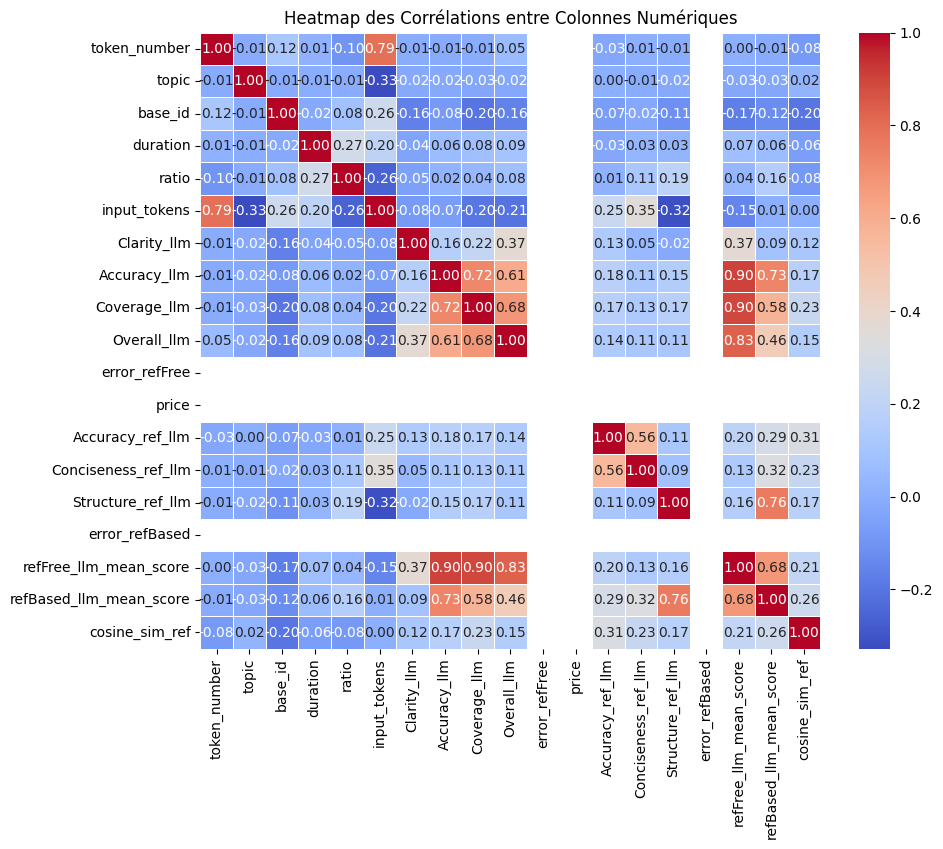

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer les colonnes numériques
numeric_cols = df_filtered.select_dtypes(include='number').columns
# Exclure les colonnes qui finissent par "_var"
filtered_cols = [col for col in numeric_cols if not col.endswith('_var')]
filtered_df = df_filtered[filtered_cols]


correlation_matrix = filtered_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap des Corrélations entre Colonnes Numériques")
plt.show()